Vamos a intentar a prededecir el precio de un coche. Usaremos los datos que hemos recopilado en *coches.net*.


Las importaciones de las librerías que se van a utilizar.

In [ ]:
import pandas as pd
import numpy as np

# upload files
from google.colab import files
import io
import matplotlib.pyplot as plt
import seaborn as sns

# formatos csv, json
import csv
import json

# etc.
import os
import pickle
from google.colab import drive
drive.mount('/content/drive')

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#funciones para la obtención de columnas con valores nulos
def columns_without_values(data):
    columns = data.isnull().sum()
    print(columns[columns > 0])

#funciones para obtener la representación de los diagramas de cajas
def draw_hist_boxplot(df, feature_name):
    sns.boxplot(x=feature_name, data=df)
    sns.stripplot(x=feature_name, data=df, color="#474646")

#funciones que se utilizan para 'corregir' valores atípicos
def replace_outliers_with_median(df, feature_name):
    Q1 = df[feature_name].quantile(0.25)
    median = df[feature_name].quantile(0.5)
    Q3 = df[feature_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_whisker = Q1 - 1.5 * IQR
    upper_whisker = Q3 + 1.5 * IQR
    df[feature_name] = np.where((df[feature_name] < lower_whisker) | 
                                (df[feature_name] > upper_whisker), 
                                 median, 
                                 df[feature_name])

# 1. Importación de datos

In [ ]:
# Transformamos los JSON
path = '/content/drive/MyDrive/IABD/datasets/cochesnet/raw'
df_cols = [
  'url',
  'color',
  'fuelType',
  'km',
  'make',
  'model',
  'price',
  'province',
  'title',
  'transmissionType',
  'year',
  'seller_type',
  'bodyType',
  'cubicCapacity',
  'doors',
  'hp'
]

# Creamos un df vacio con las columnas deseadas y obtenemos los json del local de drive
data = pd.DataFrame(columns=df_cols)
json_files = [json for json in os.listdir(path) if '.json' in json]

# recorremos los ficheros
for filename in json_files:
  # cargamos el contenido del fichero
  df = pd.read_json(path + '/' + filename)
  # eliminamos la columna datetime
  try:
    df = df.drop('datetime', axis=1)
  except KeyError:
    pass

  # Si el JSON posee 'resto_de_datos' metemos todas las columnas de dentro en el dataset principal 
  try:
    resto_de_datos = pd.json_normalize(df['resto_de_datos']).drop('url', axis=1) # Aqui eliminamos tambien la columna duplicada url de resto_de_datos
    df = df.drop('resto_de_datos', axis=1)
    df = pd.concat([df, resto_de_datos],  axis=1)
  except KeyError:
    pass
    
  # eliminamos las columnas con ID y columnas duplicadas o irrelevantes
  columnas_eliminar = ['id','brand', 'brand_id', 'fuelTypeId', 'makeId','modelId','provinceId','transmissionTypeId','model_id', 'fuelTypeId', 'fuel_types']
  df = df.drop(columnas_eliminar, axis=1)

  # Añadimos los datos al Dataset principal
  data = pd.concat([data, df])

# Eliminamos los duplicados de la url dado que la url es un identidicador inequivoco de un vehiculo
data = data.drop_duplicates(subset=['url'])



# Ahora hacemos lo mismo con los CSV
columnas_eliminar = [
  'id',
  'makeId',
  'modelId',
  'provinceId',
  'transmissionTypeId',
  'fuelTypeId'
]

csv_files = [csv for csv in os.listdir(path) if '.csv' in csv]
for filename in csv_files:
  df = pd.read_csv(path + '/' + filename).drop(columnas_eliminar, axis=1)

  # renombramos la columna body_types para poder concatenarla con bodyType del resto de ficheros
  try:
    df = df.rename(columns={'body_types':'bodyType'})
  except KeyError:
    pass

  #Eliminamos las columnas una a una dado la heterogeneidad de los ficheros (columnas que puede que esten en un fichero pero en otro no)
  columnas_eliminar_unicas = ['fecha', 'date', 'Unnamed: 0', 'seller_type_id', 'body_types_id', 'publicationDate'] #eliminamos fechas, columnas id y columnas irrelevantes
  for col in columnas_eliminar_unicas:
    try:
      df = df.drop(col, axis=1)
    except KeyError:
      pass
  
  data = pd.concat([data, df])

#Tratamiento de ciertas columna
data['color'] = data['color'].str.replace('COMMON.COLOR_', '')
data['transmissionType'] = data['transmissionType'].str.replace('COMMON.TRANSMISSION_', '')
data['bodyType'] = data['bodyType'].str.replace('BODY_TYPE_', '')

# Eliminamos los duplicados de la url dado que la url es un identidicador inequivoco de un vehiculo
data = data.drop_duplicates(subset=['url'])
# Eliminamos los registros que puedan contener valores nulos en alguna de sus columnas
data = data.dropna()
# Reiniciamos los indices del dataset
data = data.reset_index(drop=True)
data

<ipython-input-3-95a022591ca9>:87: FutureWarning: The default value of regex will change from True to False in a future version.
  data['color'] = data['color'].str.replace('COMMON.COLOR_', '')
<ipython-input-3-95a022591ca9>:88: FutureWarning: The default value of regex will change from True to False in a future version.
  data['transmissionType'] = data['transmissionType'].str.replace('COMMON.TRANSMISSION_', '')


,url,color,fuelType,km,make,model,price,province,title,transmissionType,year,seller_type,bodyType,cubicCapacity,doors,hp
0,https://www.coches.net/smart-fortwo-09-66kw-90...,RED,Gasolina,49357,SMART,fortwo,12790,Madrid,SMART fortwo 0.9 66kW 90CV COUPE 3p.,AUTOMATIC,2018,profesional,SEDAN,898.0,3,90.0
1,https://www.coches.net/smart-fortwo-09-66kw-90...,WHITE,Gasolina,69000,SMART,fortwo,13990,Zamora,SMART fortwo 0.9 66kW 90CV CABRIO Urbanshadow ...,AUTOMATIC,2019,profesional,CABRIO,898.0,2,90.0
2,https://www.coches.net/smart-fortwo-coupe-62-p...,BLACK,Gasolina,89000,SMART,fortwo,8990,Tarragona,SMART fortwo Coupe 62 Passion,AUTOMATIC,2015,profesional,SEDAN,999.0,3,84.0
3,https://www.coches.net/smart-forfour-09-66kw-9...,BLACK,Gasolina,40000,SMART,forfour,12500,Salamanca,SMART forfour 0.9 66kW 90CV SS PASSION 5p.,MANUAL,2017,profesional,SEDAN,898.0,5,90.0
4,https://www.coches.net/smart-fortwo-10-52kw-71...,BLACK,Gasolina,25000,SMART,fortwo,18900,Málaga,SMART fortwo 1.0 52kW 71CV CABRIO Urbanshadow ...,AUTOMATIC,2020,profesional,CABRIO,999.0,2,71.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12761,https://www.coches.net/mazda-cx5-22-d-110kw-15...,WHITE,Diésel,139383.0,MAZDA,CX5,20900.0,A Coruña,MAZDA CX5 2.2 D 110kW 150CV 2WD AT Evolution 5p.,MANUAL,2019.0,profesional,4x4 suv,2191.0,5.0,150.0
12762,https://www.coches.net/mazda-cx5-22-d-110kw-15...,RED,Diésel,69000.0,MAZDA,CX5,24999.0,Madrid,MAZDA CX5 2.2 D 110kW 150CV 2WD AT Zenith,AUTOMATIC,2019.0,profesional,4x4 suv,2191.0,5.0,150.0
12763,https://www.coches.net/mazda-mx5-20-118kw-160c...,WHITE,Gasolina,63912.0,MAZDA,MX5,19400.0,Madrid,MAZDA MX5 2.0 118kW 160CV Style 2p.,MANUAL,2016.0,profesional,cabrio,1998.0,2.0,160.0
12764,https://www.coches.net/mazda-cx5-22-110kw-150c...,GRAY,Diésel,79000.0,MAZDA,CX5,17400.0,Castellón,MAZDA CX5 2.2 110kW 150CV DE 2WD AT Style 5p.,AUTOMATIC,2015.0,profesional,4x4 suv,2191.0,5.0,150.0


In [ ]:
# transformamos el tipo de las columnas
data['year'] = data['year'].astype(int)
data['hp'] = data['hp'].astype(int)
data['km'] = data['km'].astype(int)
data['price'] = data['price'].astype(int)
data['doors'] = data['doors'].astype(int)

In [ ]:
# Eliminamos las columnas irrelevantes (url y titulo)
data = data.drop(['url', 'title'], axis=1)

Obtener información acerca de los datos que se acaban de leer.

In [ ]:
data.head()

,color,fuelType,km,make,model,price,province,transmissionType,year,seller_type,bodyType,cubicCapacity,doors,hp
0,RED,Gasolina,49357,SMART,fortwo,12790,Madrid,AUTOMATIC,2018,profesional,SEDAN,898.0,3,90
1,WHITE,Gasolina,69000,SMART,fortwo,13990,Zamora,AUTOMATIC,2019,profesional,CABRIO,898.0,2,90
2,BLACK,Gasolina,89000,SMART,fortwo,8990,Tarragona,AUTOMATIC,2015,profesional,SEDAN,999.0,3,84
3,BLACK,Gasolina,40000,SMART,forfour,12500,Salamanca,MANUAL,2017,profesional,SEDAN,898.0,5,90
4,BLACK,Gasolina,25000,SMART,fortwo,18900,Málaga,AUTOMATIC,2020,profesional,CABRIO,999.0,2,71


In [ ]:
data.dtypes

color                object
fuelType             object
km                    int64
make                 object
model                object
price                 int64
province             object
transmissionType     object
year                  int64
seller_type          object
bodyType             object
cubicCapacity       float64
doors                 int64
hp                    int64
dtype: object

In [ ]:
data.describe()

,km,price,year,cubicCapacity,doors,hp
count,12766.000000,12766.000000,12766.000000,12766.000000,12766.000000,12766.000000
mean,73530.692151,24384.970703,2018.184944,1706.700533,4.772599,147.828921
std,41970.876519,17712.342653,2.339168,554.373070,0.644775,71.667008
min,10000.000000,4000.000000,2012.000000,647.000000,2.000000,60.000000
25%,38967.250000,15500.000000,2017.000000,1395.000000,5.000000,110.000000
50%,68404.000000,20890.000000,2018.000000,1598.000000,5.000000,130.000000
75%,100000.000000,27900.000000,2020.000000,1995.000000,5.000000,156.000000
max,180000.000000,450000.000000,2022.000000,6496.000000,5.000000,800.000000


También existe la posibilidad de que el dataset tenga filas duplicadas, que hay que eliminar:

**data.drop_duplicates(subset=None, inplace=True)**

**data.drop_duplicates(subset=['id'], keep='first')**

# 2. Preparación de los datos

Una vez leido el dataset transformar los datos a un formato 'válido'.

Analizar los valores nulos y sustituirlos por otros valores.

In [ ]:
#información detallada por cada una de las columnas indicando si tiene o no valores nulos
pd.isnull(data).any()

color               False
fuelType            False
km                  False
make                False
model               False
price               False
province            False
transmissionType    False
year                False
seller_type         False
bodyType            False
cubicCapacity       False
doors               False
hp                  False
dtype: bool

In [ ]:
#información de aquellas columnas que tienen valores nulos, indicando el número de veces que el valor es nulo
columns_without_values(data)

Series([], dtype: int64)


En el caso de las columnas numéricas, lo que se puede hacer es sustituir los valores nulos por la media de los valores de la columna.

En el caso de las columnas de texto, lo que se puede hacer es sustituir los valores nulos por el último valor leído de la propia columna.

En el caso de las columnas categóricas (las que toman sólo un pequeño conjunto de valores), lo que se puede hacer es sustituir los valores nulos por el valor que más veces aparece en la propia columna.

También se puede utilizar la interpolación para sustituir los valores nulos: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html#pandas.DataFrame.interpolate

En general, se trata de sustituir los valores nulos por otros valores.

Si es la propia columna objetivo la que presenta valores nulos, lo que se debe hacer es eliminar esas filas.

También es necesario comprobar que todos los datos tienen valores correctos: desde 2012 a 2022, desde 10.000 km a 180.000 km, etc.

In [ ]:
#sustitución del valor nulo por el último valor de la misma columna

In [ ]:
#sustitución del valor nulo por el valor que con más frecuencia se utiliza

In [ ]:
#sustitución del valor nulo por la media de la columna

In [ ]:
#eliminación de las filas en las que el valor objetivo es nulo

#después de eliminar filas hay que resetear el dataset
data.reset_index(drop=True, inplace=True)

# 3. Normalización de los datos

Definimos listas en las que se guardan los nombre de los campos numéricos y los de los campos categóricos. No se incluye el nombre del campo objetivo.

In [ ]:
data

,color,fuelType,km,make,model,price,province,transmissionType,year,seller_type,bodyType,cubicCapacity,doors,hp
0,RED,Gasolina,49357,SMART,fortwo,12790,Madrid,AUTOMATIC,2018,profesional,SEDAN,898.0,3,90
1,WHITE,Gasolina,69000,SMART,fortwo,13990,Zamora,AUTOMATIC,2019,profesional,CABRIO,898.0,2,90
2,BLACK,Gasolina,89000,SMART,fortwo,8990,Tarragona,AUTOMATIC,2015,profesional,SEDAN,999.0,3,84
3,BLACK,Gasolina,40000,SMART,forfour,12500,Salamanca,MANUAL,2017,profesional,SEDAN,898.0,5,90
4,BLACK,Gasolina,25000,SMART,fortwo,18900,Málaga,AUTOMATIC,2020,profesional,CABRIO,999.0,2,71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12761,WHITE,Diésel,139383,MAZDA,CX5,20900,A Coruña,MANUAL,2019,profesional,4x4 suv,2191.0,5,150
12762,RED,Diésel,69000,MAZDA,CX5,24999,Madrid,AUTOMATIC,2019,profesional,4x4 suv,2191.0,5,150
12763,WHITE,Gasolina,63912,MAZDA,MX5,19400,Madrid,MANUAL,2016,profesional,cabrio,1998.0,2,160
12764,GRAY,Diésel,79000,MAZDA,CX5,17400,Castellón,AUTOMATIC,2015,profesional,4x4 suv,2191.0,5,150


In [ ]:
campos_numericos = ['km', 'price', 'year', 'cubicCapacity', 'doors', 'hp']

campos_categoricos = ['color', 'fuelType', 'make', 'model', 'province', 'transmissionType', 'seller_type', 'bodyType']

all_feature_names = campos_numericos + campos_categoricos

target = 'price' # o como se llame

In [ ]:
for field in campos_categoricos:
  print(field, data[field].unique())
  print('_____________________________________________________________________')

In [ ]:
for field in campos_categoricos:
  # Pasamos a mayusculas
  data[field] = data[field].str.upper()

data

,color,fuelType,km,make,model,price,province,transmissionType,year,seller_type,bodyType,cubicCapacity,doors,hp
0,RED,GASOLINA,49357,SMART,FORTWO,12790,MADRID,AUTOMATIC,2018,PROFESIONAL,SEDAN,898.0,3,90
1,WHITE,GASOLINA,69000,SMART,FORTWO,13990,ZAMORA,AUTOMATIC,2019,PROFESIONAL,CABRIO,898.0,2,90
2,BLACK,GASOLINA,89000,SMART,FORTWO,8990,TARRAGONA,AUTOMATIC,2015,PROFESIONAL,SEDAN,999.0,3,84
3,BLACK,GASOLINA,40000,SMART,FORFOUR,12500,SALAMANCA,MANUAL,2017,PROFESIONAL,SEDAN,898.0,5,90
4,BLACK,GASOLINA,25000,SMART,FORTWO,18900,MÁLAGA,AUTOMATIC,2020,PROFESIONAL,CABRIO,999.0,2,71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12761,WHITE,DIÉSEL,139383,MAZDA,CX5,20900,A CORUÑA,MANUAL,2019,PROFESIONAL,4X4 SUV,2191.0,5,150
12762,RED,DIÉSEL,69000,MAZDA,CX5,24999,MADRID,AUTOMATIC,2019,PROFESIONAL,4X4 SUV,2191.0,5,150
12763,WHITE,GASOLINA,63912,MAZDA,MX5,19400,MADRID,MANUAL,2016,PROFESIONAL,CABRIO,1998.0,2,160
12764,GRAY,DIÉSEL,79000,MAZDA,CX5,17400,CASTELLÓN,AUTOMATIC,2015,PROFESIONAL,4X4 SUV,2191.0,5,150


Se visualizan los histogramas de las columnas numéricas.

<ipython-input-13-f901a12af636>:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data[campos_numericos].hist(ax=plt.figure(figsize=(15,15)).gca())


array([[<Axes: title={'center': 'km'}>,
        <Axes: title={'center': 'price'}>],
       [<Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'cubicCapacity'}>],
       [<Axes: title={'center': 'doors'}>,
        <Axes: title={'center': 'hp'}>]], dtype=object)

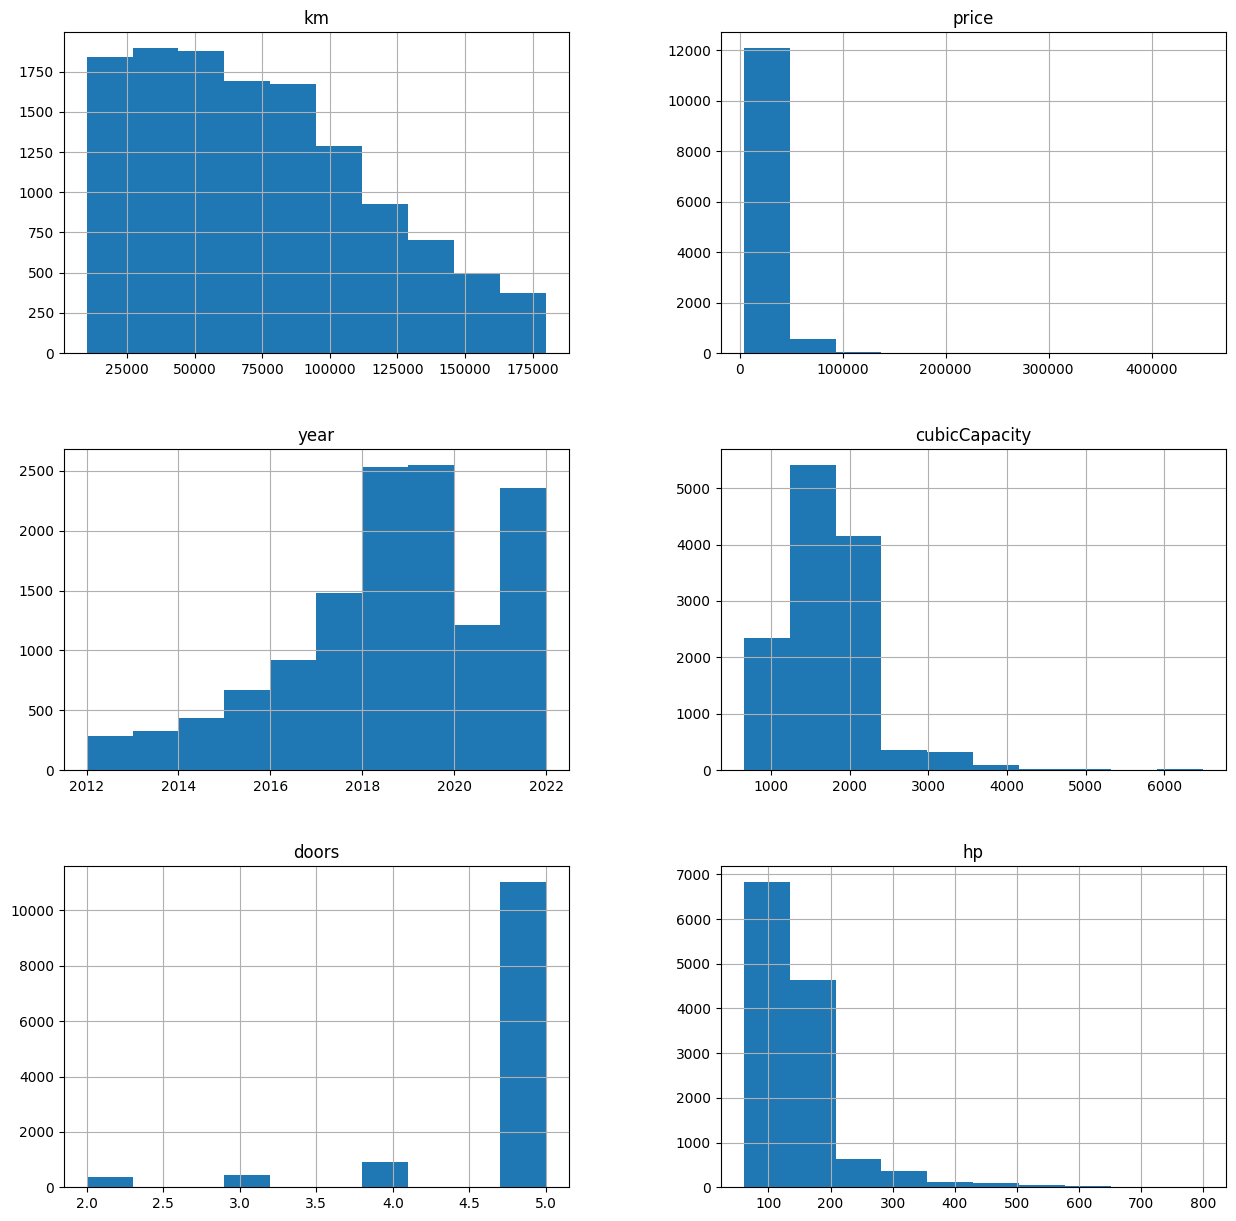

In [ ]:
#histogramas de las columnas numéricas
data[campos_numericos].hist(ax=plt.figure(figsize=(15,15)).gca())

#al ejecutar estos histogramas por primera vez, lo que se puede observar es que en realidad muchas
#de estas variables numéricas en realidad son categóricas

Se visualizan los diagramas de cajas. En el caso en el que muchos valores se salgan del diagrama, se puede intentar hacer una normalización de los datos que acerque todos los outliers al conjunto de datos.

También existe la posibilidad de eliminar directamente aquellos datos que se consideren erróneos.

La normalización se supone que hace que mejore el comportamiento del algoritmo de creación del modelo, se puede comprobar si realmente se obtienen mejores resultados, comparando ambos modelos.

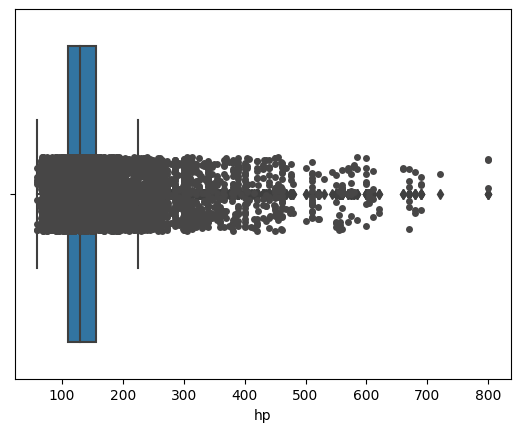

In [ ]:
#visualizar los diagramas para todas las propiedades numéricas
draw_hist_boxplot(data, 'hp')

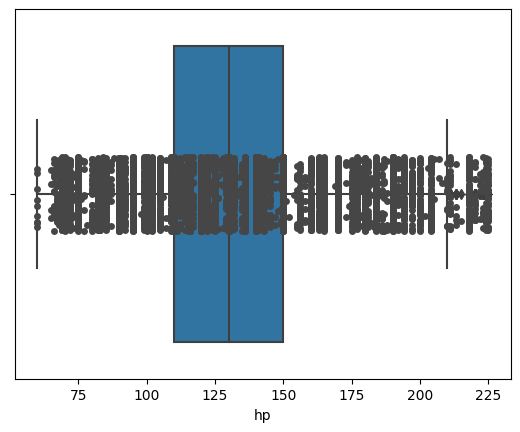

In [ ]:
replace_outliers_with_median(data, 'hp')
draw_hist_boxplot(data, 'hp')

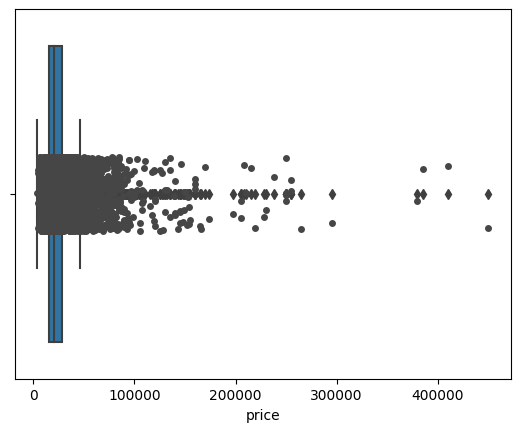

In [ ]:
#visualizar los diagramas para todas las propiedades numéricas
draw_hist_boxplot(data, 'price')

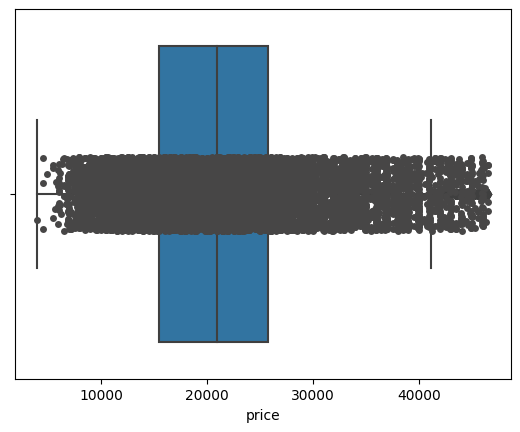

In [ ]:
replace_outliers_with_median(data, 'price')
draw_hist_boxplot(data, 'price')

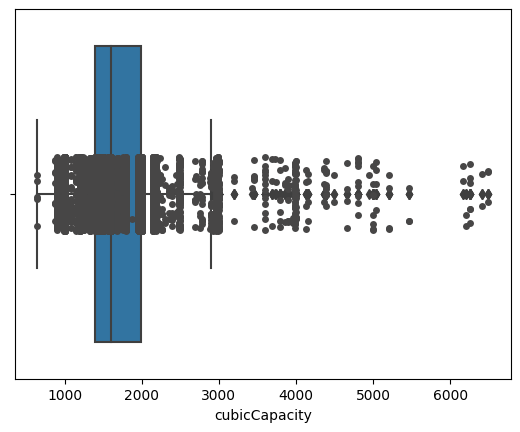

In [ ]:
#visualizar los diagramas para todas las propiedades numéricas
draw_hist_boxplot(data, 'cubicCapacity')

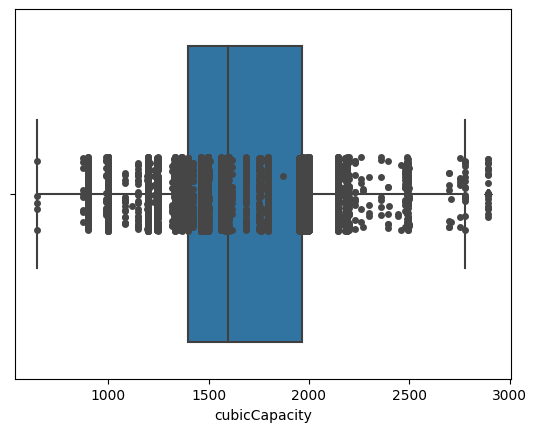

In [ ]:
replace_outliers_with_median(data, 'cubicCapacity')
draw_hist_boxplot(data, 'cubicCapacity')

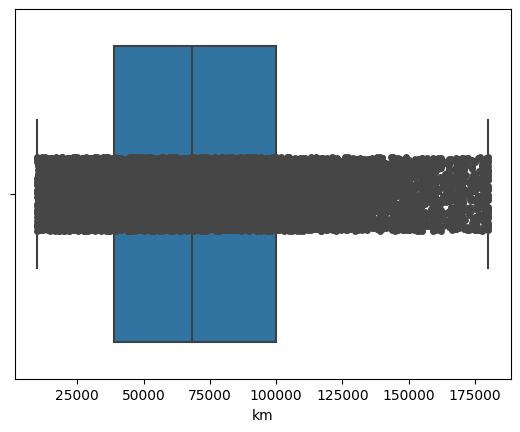

In [ ]:
#visualizar los diagramas para todas las propiedades numéricas
draw_hist_boxplot(data, 'km')

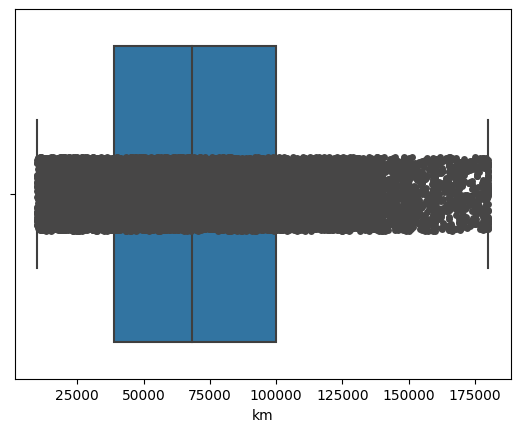

In [ ]:
replace_outliers_with_median(data, 'km')
draw_hist_boxplot(data, 'km')

In [ ]:
#se puede calcular la desviación de la distribución, si el valor es negativo la desviación es a la izquierda y si es positivo es a la derecha
print(data['km'].skew())

0.5124284790457847


Una vez corregidos los valores nulos y corregidos los outliers, se puede analizar la relación de los atributos con el objetivo.

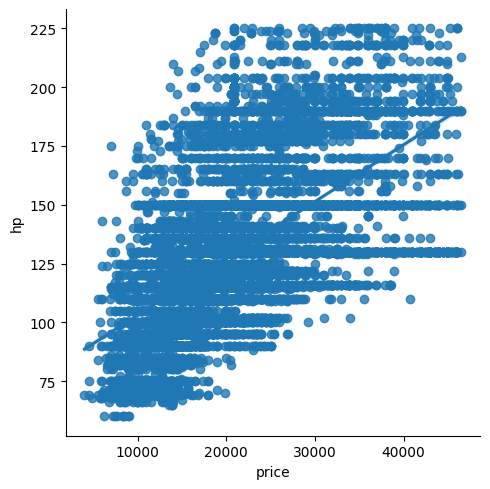

In [ ]:
sns.lmplot(data=data, x='price', y='hp', order=1)
#sns.lmplot(data=data, x="hp", y="price", order=1)

Una vez 'normalizados' todos los valores y habiendo acercado los outliers al conjunto de datos, se puede realizar una segunda normalización en la que se intenta transformas los valores de cada columna de tal manera que la media sea 0 y la desviación típica 1. Esto se puede hacer mediante el escalado de los valores numéricos.

In [ ]:
scaler = StandardScaler()
data[campos_numericos] = scaler.fit_transform(data[campos_numericos])
data[campos_numericos].hist(ax=plt.figure(figsize=(15,15)).gca())

NameError: ignored

También existen otros métodos de normalización.

In [ ]:
scaler = MinMaxScaler()
data[campos_numericos] = scaler.fit_transform(data[campos_numericos])

# Guarda el objeto MinMaxScaler en un archivo
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

<ipython-input-25-4d0aaef05a18>:1: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data[campos_numericos].hist(ax=plt.figure(figsize=(15,15)).gca())


array([[<Axes: title={'center': 'km'}>,
        <Axes: title={'center': 'price'}>],
       [<Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'cubicCapacity'}>],
       [<Axes: title={'center': 'doors'}>,
        <Axes: title={'center': 'hp'}>]], dtype=object)

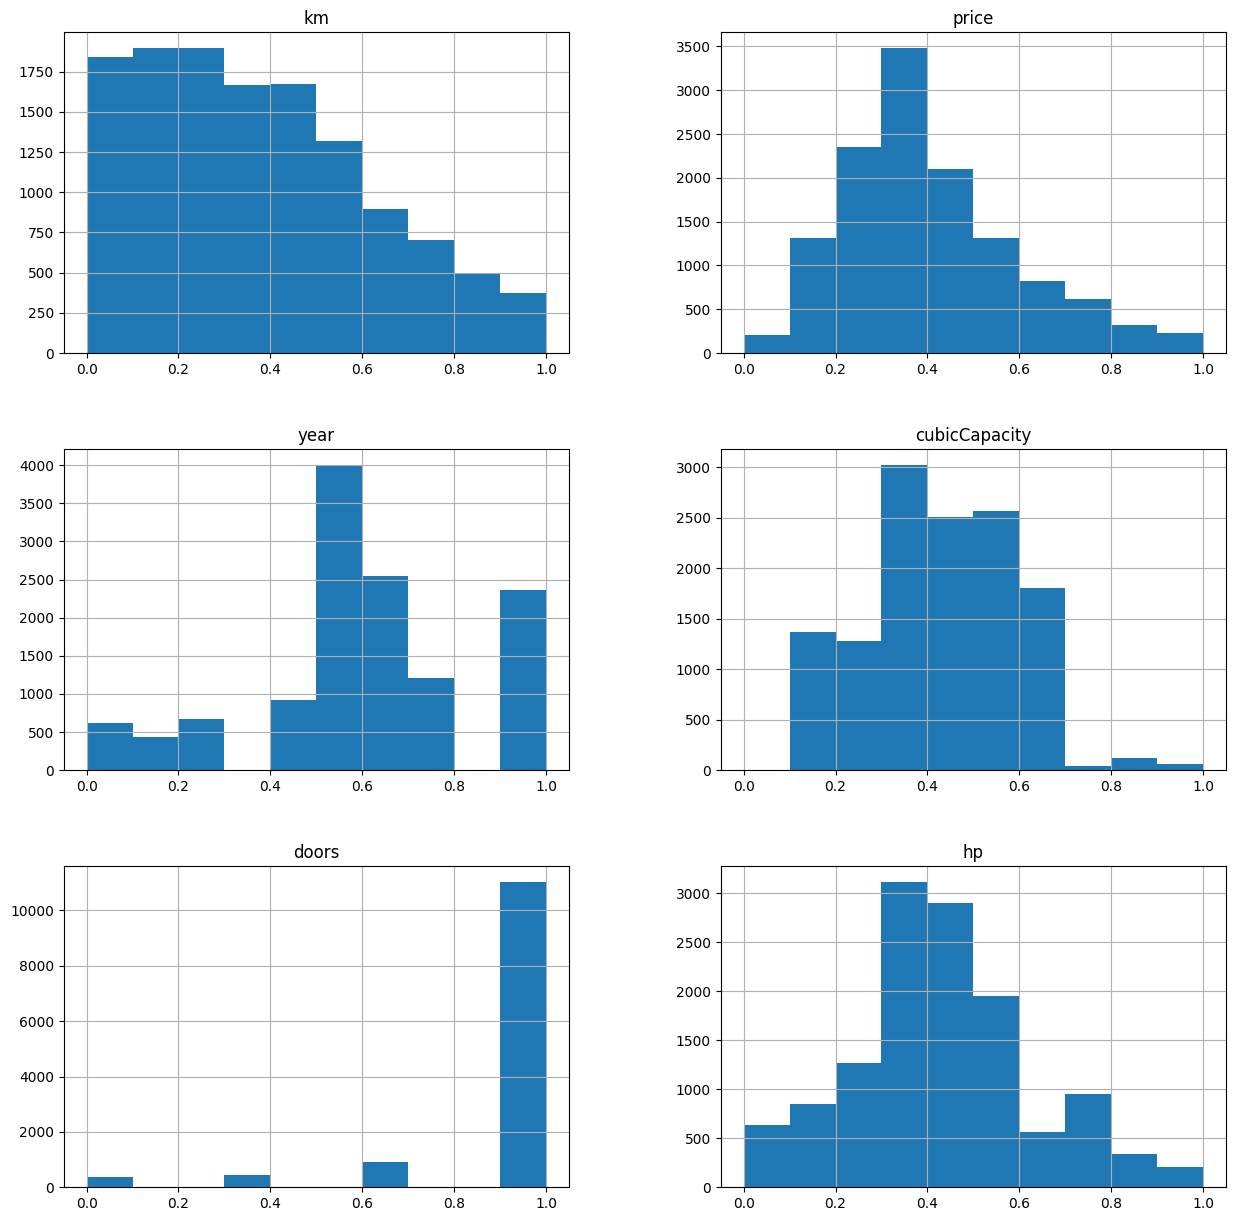

In [ ]:
data[campos_numericos].hist(ax=plt.figure(figsize=(15,15)).gca())

['km', 'price', 'year', 'cubicCapacity', 'doors', 'hp']

Para que el algoritmo de generación del modelo funcione es necesario eliminar los valores nulos.

La búsqueda y la corrección de los outliers es convienete realizarla para evitar que datos posiblemente erróneos alteren el modelo que se genera.

En cuanto al escalado es posible que escalando los datos se mejoren los resultados que se obtienen, aunque también es conveniente comparar los resultados que se obtienen, por si el escalado produce resultados peores.

In [ ]:
# Exportamos el Dataset
data.to_json('/content/drive/MyDrive/IABD/datasets/cochesnet/cochesnet.json')

# 4. Importancia de los datos y división del conjunto de datos

Para estudiar la relación que existe entre todas las variables se puede generar un 'mapa de calor'. Si se observa que alguna variable realmente no tiene ninguna influencia sobre la variable objetivo, se puede eliminar esa propiedad.

In [ ]:
# importamos el dataset de un json con los datos ya tratados
data = pd.read_json('/content/drive/MyDrive/IABD/datasets/cochesnet/cochesnet.json')

In [ ]:
data

,color,fuelType,km,make,model,price,province,transmissionType,year,seller_type,bodyType,cubicCapacity,doors,hp
0,RED,GASOLINA,0.231512,SMART,FORTWO,0.206824,MADRID,AUTOMATIC,0.6,PROFESIONAL,SEDAN,0.111704,0.333333,0.181818
1,WHITE,GASOLINA,0.347059,SMART,FORTWO,0.235059,ZAMORA,AUTOMATIC,0.7,PROFESIONAL,CABRIO,0.111704,0.000000,0.181818
2,BLACK,GASOLINA,0.464706,SMART,FORTWO,0.117412,TARRAGONA,AUTOMATIC,0.3,PROFESIONAL,SEDAN,0.156653,0.333333,0.145455
3,BLACK,GASOLINA,0.176471,SMART,FORFOUR,0.200000,SALAMANCA,MANUAL,0.5,PROFESIONAL,SEDAN,0.111704,1.000000,0.181818
4,BLACK,GASOLINA,0.088235,SMART,FORTWO,0.350588,MÁLAGA,AUTOMATIC,0.8,PROFESIONAL,CABRIO,0.156653,0.000000,0.066667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12761,WHITE,DIÉSEL,0.761076,MAZDA,CX5,0.397647,A CORUÑA,MANUAL,0.7,PROFESIONAL,4X4 SUV,0.687138,1.000000,0.545455
12762,RED,DIÉSEL,0.347059,MAZDA,CX5,0.494094,MADRID,AUTOMATIC,0.7,PROFESIONAL,4X4 SUV,0.687138,1.000000,0.545455
12763,WHITE,GASOLINA,0.317129,MAZDA,MX5,0.362353,MADRID,MANUAL,0.4,PROFESIONAL,CABRIO,0.601246,0.000000,0.606061
12764,GRAY,DIÉSEL,0.405882,MAZDA,CX5,0.315294,CASTELLÓN,AUTOMATIC,0.3,PROFESIONAL,4X4 SUV,0.687138,1.000000,0.545455


<ipython-input-4-ad386169dba0>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), cmap='BrBG', annot=True)


<Axes: >

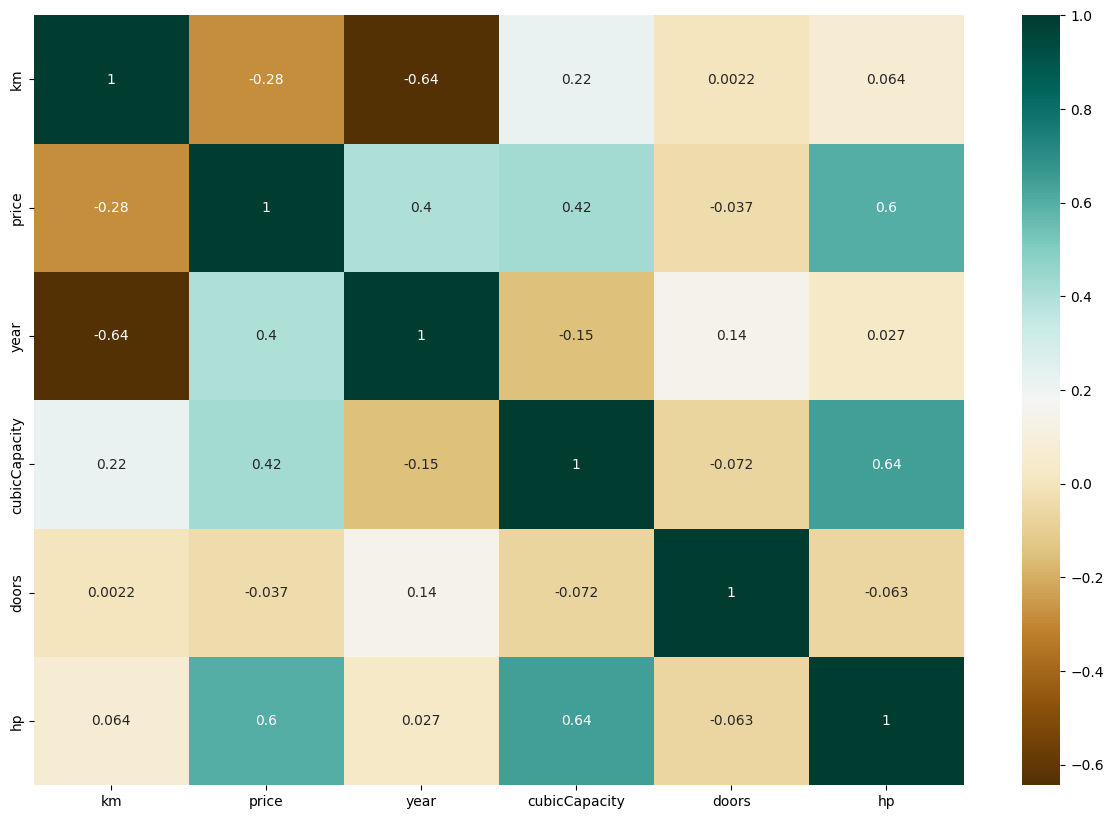

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(data.corr(), cmap='BrBG', annot=True)

Para eliminar una variable del dataset se puede utilizar el método drop(). El atributo id seguro que no aporta nada y se puede eliminar. Pero también ha resultado util mantenerlo hasta este momento para poder eliminar filas duplicadas.

In [ ]:
data.drop(['id'], axis=1, inplace=True)

También se puede dibujar los diagramas de cajas para ver la relación de la variable objetivo con las variables categóricas.

<Axes: xlabel='fuelType', ylabel='price'>

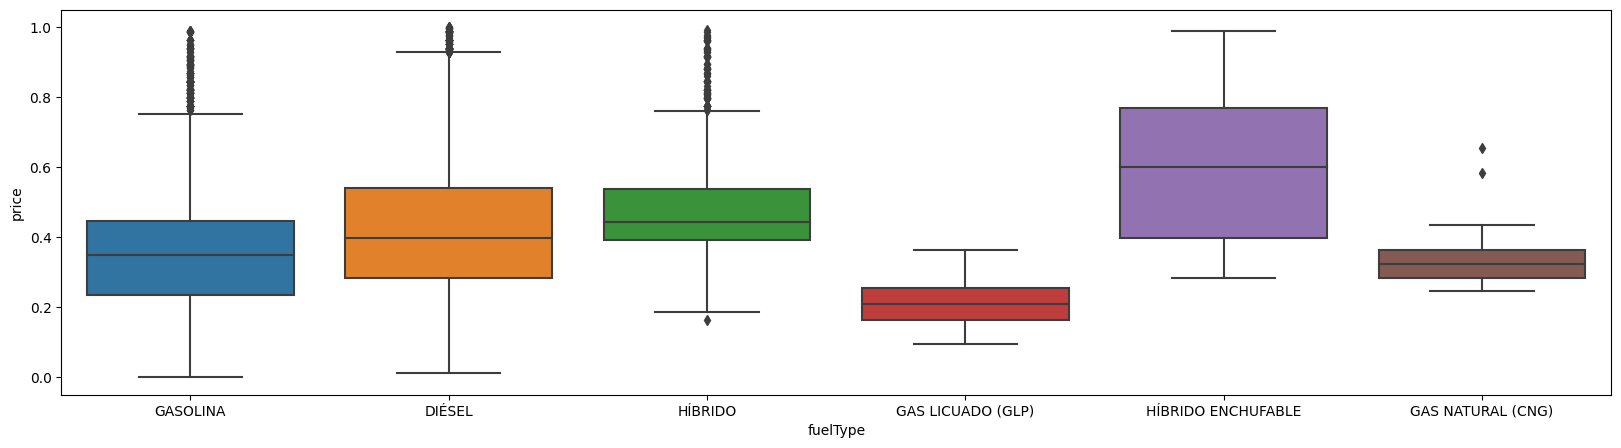

In [ ]:
plt.figure(figsize=(20,5))
sns.boxplot(x='fuelType', y='price', data=data) # etc.

In [ ]:
['color', 'fuelType', 'make', 'model', 'province', 'transmissionType', 'seller_type', 'bodyType']

<Axes: xlabel='make', ylabel='price'>

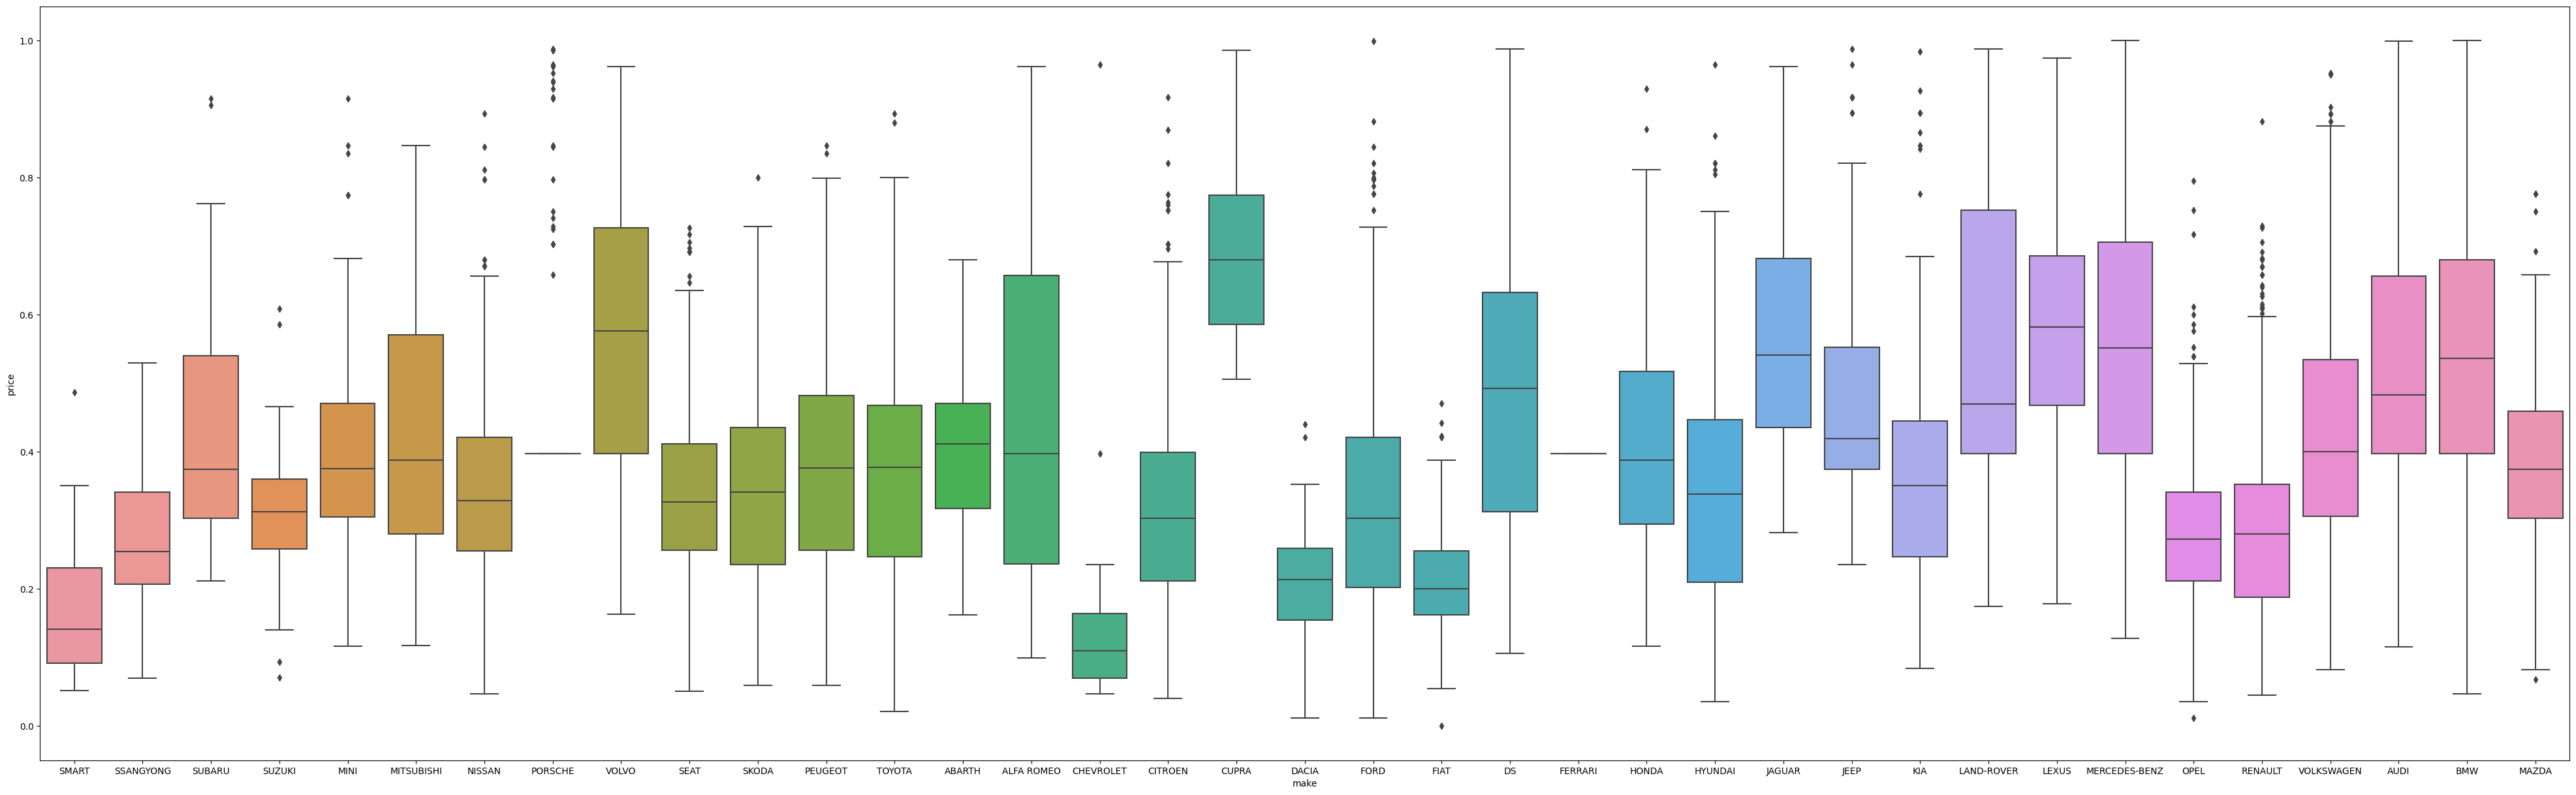

In [ ]:
plt.figure(figsize=(50,15))
sns.boxplot(x='make', y='price', data=data) # etc.

<Axes: xlabel='transmissionType', ylabel='price'>

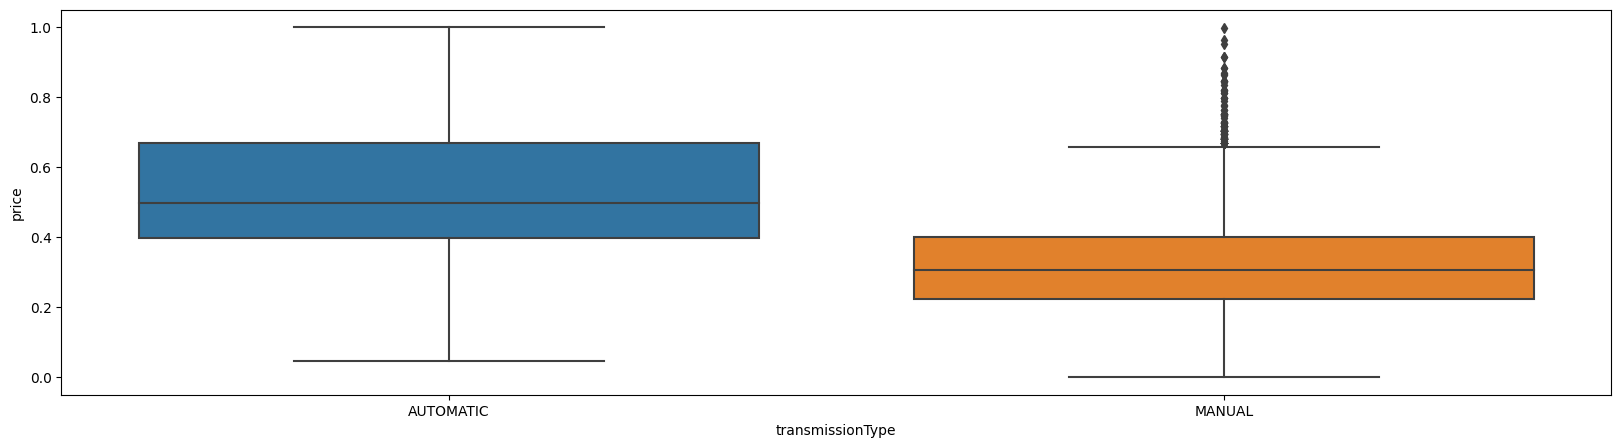

In [ ]:
plt.figure(figsize=(20,5))
sns.boxplot(x='transmissionType', y='price', data=data) # etc.

<Axes: xlabel='bodyType', ylabel='price'>

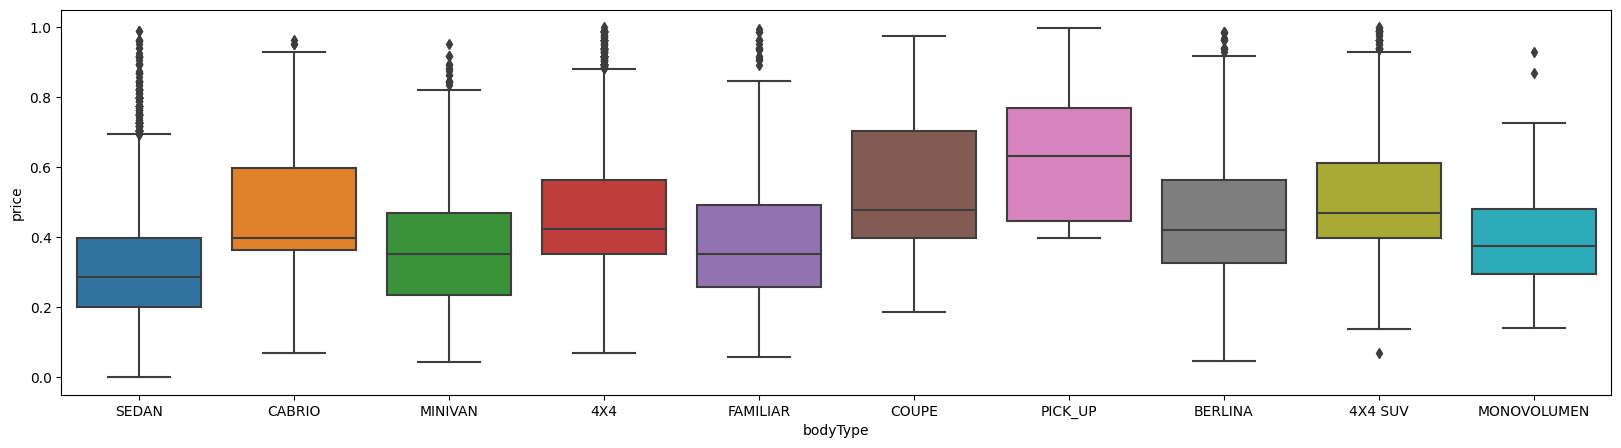

In [ ]:
plt.figure(figsize=(20,5))
sns.boxplot(x='bodyType', y='price', data=data) # etc.

In [ ]:
sns.pairplot(data[campos_numericos + [target]])

Una vez vistas las relaciones de las variables categóricas con la variable objetivo, se puede decidir eliminar aquellas variables categóricas que no tengan prácticamente ninguna influencia sobre la variable objetivo.

In [ ]:
campos_numericos = ['km', 'year', 'cubicCapacity', 'doors', 'hp']

campos_categoricos = ['color', 'fuelType', 'make', 'model', 'province', 'transmissionType', 'seller_type', 'bodyType']


all_feature_names = campos_numericos + campos_categoricos

target = 'price'

#used_features = all_feature_names.append(target)
used_features = all_feature_names + [target]

In [ ]:
used_features

['km',
 'year',
 'cubicCapacity',
 'doors',
 'hp',
 'color',
 'fuelType',
 'make',
 'model',
 'province',
 'transmissionType',
 'seller_type',
 'bodyType',
 'price']

Para crear las conjuntos de datos de entrenamiento y de prueba se ha de dividir el dataset. Primero se obtiene los conjuntos de entranamiento y de prueba. El conjunto de entrenamiento a su vez se divide en el conjunto que se utiliza para realizar el entrenamiento y el que se utiliza para realizar la validación.

In [ ]:
train_data, test_data, _ = np.split(data.sample(frac=1, random_state=123), [int(0.70*len(data)), int(len(data))])

X_train_full, X_test = train_test_split(data[used_features], test_size=0.3, random_state=12)
X_train, X_val = train_test_split(X_train_full, test_size=0.33, random_state=1)

print(len(train_data), len(test_data))
print(len(X_train_full), len(X_test), len(X_train), len(X_val))

8936 3830
8936 3830 5987 2949


Finalmente se elimina la variable objetivo de los conjuntos de entrenamiento y se guarda en variables auxiliares.

In [ ]:
y_train = X_train[target].values
y_val = X_val[target].values
y_test = X_test[target].values

X_train.drop([target], axis=1, inplace=True)
X_val.drop([target], axis=1, inplace=True)
X_test.drop([target], axis=1, inplace=True)

# 5. Ingeniería de propiedades categóricas

Todas las propiedades categóricas se han de convertir a forma numérica de tal forma que puedan ser utilizadas por el algoritmo de aprendizaje.

https://datascience.stackexchange.com/questions/9443/when-to-use-one-hot-encoding-vs-labelencoder-vs-dictvectorizor

In [ ]:
#las filas se convierten a formato de diccionario
train_dict = X_train[all_feature_names].to_dict(orient='records')

Las propiedades categóricas se transforman.

In [ ]:
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)
X_train = dv.transform(train_dict)

Para visualizar los valores de las propiedades categóricas.

In [ ]:
X_train[0]

Para visualizar la transformación de las propiedades categóricas.

In [ ]:
dv.get_feature_names_out()

# 6. Entrenamiento del modelo

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

Obtenemos su puntuación.

In [ ]:
model.score(X_train, y_train)

0.7319850301954459

Obtenemos la puntuación del modelo con los datos de validación.

In [ ]:
X_val = dv.transform(X_val[all_feature_names].to_dict(orient='records'))
val = model.score(X_val, y_val)

Obtenemos la puntuación del modelo con los datos de prueba.

In [ ]:
X_test = dv.transform(X_test[all_feature_names].to_dict(orient='records'))
y_pred = model.predict(X_test)
model.score(X_test, y_test)

-6.017734243569735e+22

Calculamos los indicadores: error cuadrático medio, r cuadrado y la varianza.

In [ ]:
print ("MSE:", metrics.mean_squared_error(y_pred , y_test))
print ("R^2:", metrics.r2_score(y_pred , y_test))
print ("var:", y_pred.var(), y_test.var())

MSE: 2.137788163391843e+21
R^2: -0.00011131251665630337
var: 2.1375502272965635e+21 0.03552480180852423


Representamos gráficamente los resultados predichos y los resultados reales.

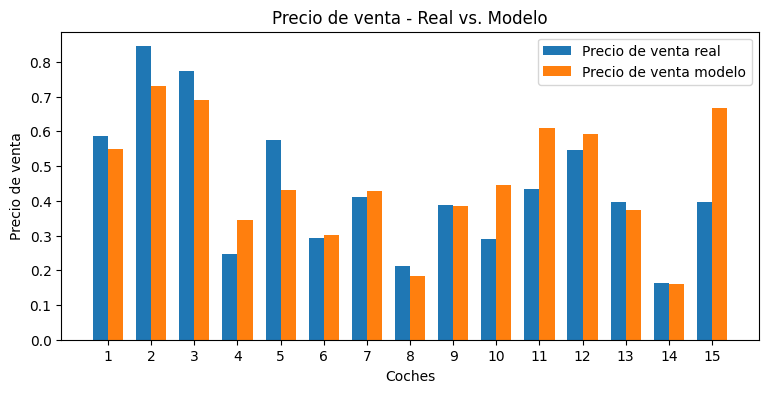

In [ ]:
ind = np.arange(15)
width = 0.35

plt.figure(figsize=(9,4))
plt.bar(ind, y_test[:15], width, label='Precio de venta real')
plt.bar(ind+width, y_pred[:15], width, label='Precio de venta modelo')

plt.xticks(ind+width/2, np.arange(1, 16))
plt.legend(loc='best')

plt.xlabel('Coches')
plt.ylabel('Precio de venta')
plt.title('Precio de venta - Real vs. Modelo')

plt.show()

## 6.1. Otros modelos

A continuación se pueden costruir otros modelos utilizando algoritmos diferentes.

0.7319850301954459
-1.1334047850425204e+22
-6.017734243569735e+22
MSE: 2.137788163391843e+21
R^2: -0.00011131251665630337
var: 2.1375502272965635e+21 0.03552480180852423


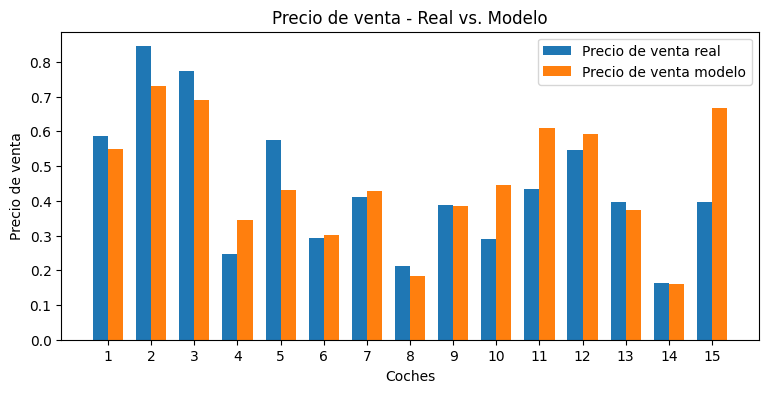

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(model.score(X_train, y_train))
print(model.score(X_val, y_val))
print(model.score(X_test, y_test))

# print ("Coeff and intercept:", model.coef_ , model.intercept_)

print ("MSE:", metrics.mean_squared_error(y_pred , y_test))
print ("R^2:", metrics.r2_score(y_pred , y_test))
print ("var:", y_pred.var(), y_test.var())

ind = np.arange(15)
width = 0.35

plt.figure(figsize=(9,4))
plt.bar(ind, y_test[:15], width, label='Precio de venta real')
plt.bar(ind+width, y_pred[:15], width, label='Precio de venta modelo')

plt.xticks(ind+width/2, np.arange(1, 16))
plt.legend(loc='best')

plt.xlabel('Coches')
plt.ylabel('Precio de venta')
plt.title('Precio de venta - Real vs. Modelo')

plt.show()

0.0
-2.7023059957720363e-05
-6.791475538436842e-05
MSE: 0.035527214466749134
R^2: 0.0
var: 0.0 0.03552480180852423


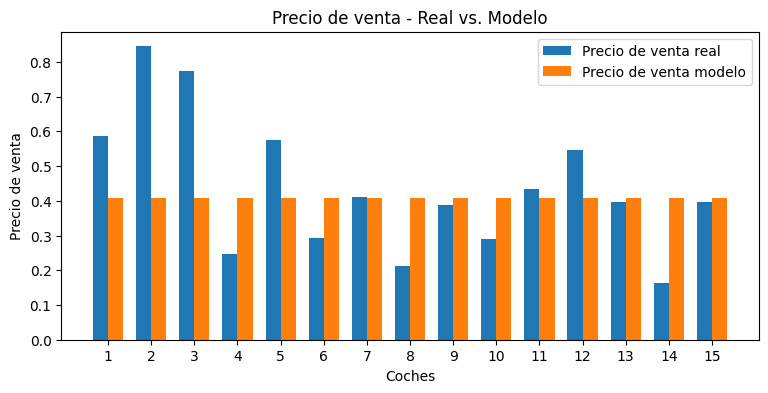

In [ ]:
from sklearn.linear_model import Lasso

lasso_model = Lasso(alpha = .3)
lasso_model.fit(X_train , y_train)
y_pred = lasso_model.predict(X_test)

print(lasso_model.score(X_train, y_train))
print(lasso_model.score(X_val, y_val))
print(lasso_model.score(X_test, y_test))

print ("MSE:", metrics.mean_squared_error(y_pred , y_test))
print ("R^2:", metrics.r2_score(y_pred , y_test))
print ("var:", y_pred.var(), y_test.var())

ind = np.arange(15)
width = 0.35

plt.figure(figsize=(9,4))
plt.bar(ind, y_test[:15], width, label='Precio de venta real')
plt.bar(ind+width, y_pred[:15], width, label='Precio de venta modelo')

plt.xticks(ind+width/2, np.arange(1, 16))
plt.legend(loc='best')

plt.xlabel('Coches')
plt.ylabel('Precio de venta')
plt.title('Precio de venta - Real vs. Modelo')

plt.show()

0.849712209200891
0.726547291071477
0.7169094432040162
MSE: 0.010056735924042097
R^2: 0.6030352919106
var: 0.02533408063514107 0.03552480180852423


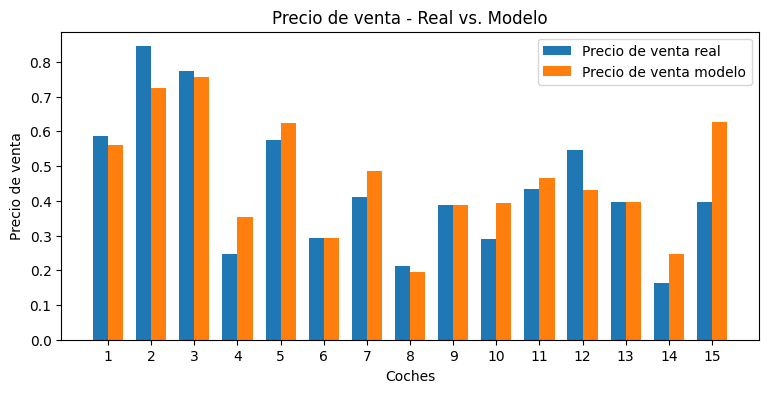

In [ ]:
from sklearn import svm

svm_model = svm.SVR()
svm_model.fit(X_train , y_train)
y_pred = svm_model.predict(X_test)

print(svm_model.score(X_train, y_train))
print(svm_model.score(X_val, y_val))
print(svm_model.score(X_test, y_test))

print ("MSE:", metrics.mean_squared_error(y_pred , y_test))
print ("R^2:", metrics.r2_score(y_pred , y_test))
print ("var:", y_pred.var(), y_test.var())

ind = np.arange(15)
width = 0.35

plt.figure(figsize=(9,4))
plt.bar(ind, y_test[:15], width, label='Precio de venta real')
plt.bar(ind+width, y_pred[:15], width, label='Precio de venta modelo')

plt.xticks(ind+width/2, np.arange(1, 16))
plt.legend(loc='best')

plt.xlabel('Coches')
plt.ylabel('Precio de venta')
plt.title('Precio de venta - Real vs. Modelo')

plt.show()

0.7594709022367849
0.7287961856725695
0.7188280589286838
MSE: 0.00998857748067656
R^2: 0.6336725039685305
var: 0.02726679702966792 0.03552480180852423


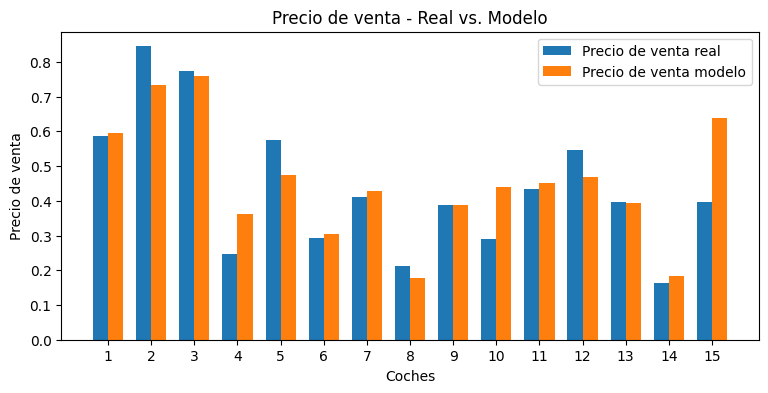

In [ ]:
from sklearn import linear_model

bayes_model = linear_model.BayesianRidge()
bayes_model.fit(X_train , y_train)
y_pred = bayes_model.predict(X_test)

print(bayes_model.score(X_train, y_train))
print(bayes_model.score(X_val, y_val))
print(bayes_model.score(X_test, y_test))

print ("MSE:", metrics.mean_squared_error(y_pred , y_test))
print ("R^2:", metrics.r2_score(y_pred , y_test))
print ("var:", y_pred.var(), y_test.var())

ind = np.arange(15)
width = 0.35

plt.figure(figsize=(9,4))
plt.bar(ind, y_test[:15], width, label='Precio de venta real')
plt.bar(ind+width, y_pred[:15], width, label='Precio de venta modelo')

plt.xticks(ind+width/2, np.arange(1, 16))
plt.legend(loc='best')

plt.xlabel('Coches')
plt.ylabel('Precio de venta')
plt.title('Precio de venta - Real vs. Modelo')

plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_base.py:116: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


0.0
-2.7023059957720363e-05
-6.791475538436842e-05
MSE: 0.035527214466749134
R^2: 0.0
var: 0.0 0.03552480180852423


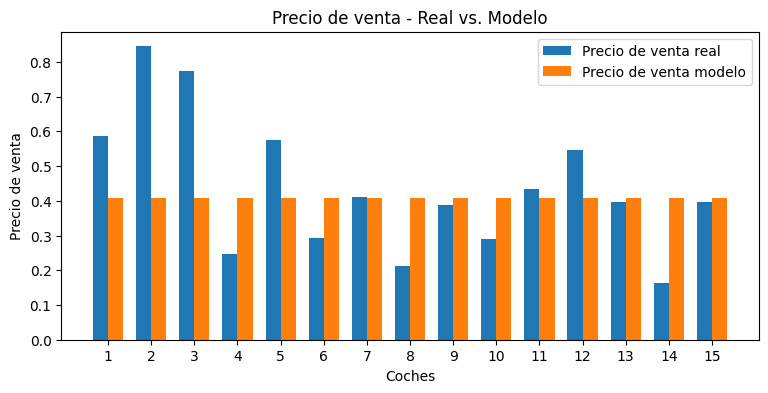

In [ ]:
from sklearn import linear_model

lasso_lars_model = linear_model.LassoLars(alpha=.1, normalize=False)
lasso_lars_model.fit(X_train , y_train)
y_pred = lasso_lars_model.predict(X_test)

print(lasso_lars_model.score(X_train, y_train))
print(lasso_lars_model.score(X_val, y_val))
print(lasso_lars_model.score(X_test, y_test))

print ("MSE:", metrics.mean_squared_error(y_pred , y_test))
print ("R^2:", metrics.r2_score(y_pred , y_test))
print ("var:", y_pred.var(), y_test.var())

ind = np.arange(15)
width = 0.35

plt.figure(figsize=(9,4))
plt.bar(ind, y_test[:15], width, label='Precio de venta real')
plt.bar(ind+width, y_pred[:15], width, label='Precio de venta modelo')

plt.xticks(ind+width/2, np.arange(1, 16))
plt.legend(loc='best')

plt.xlabel('Coches')
plt.ylabel('Precio de venta')
plt.title('Precio de venta - Real vs. Modelo')

plt.show()

0.7611376694723457
0.7248618212861336
0.7128863562888779
MSE: 0.010199655289360853
R^2: 0.6339452702148737
var: 0.027863744023600073 0.03552480180852423


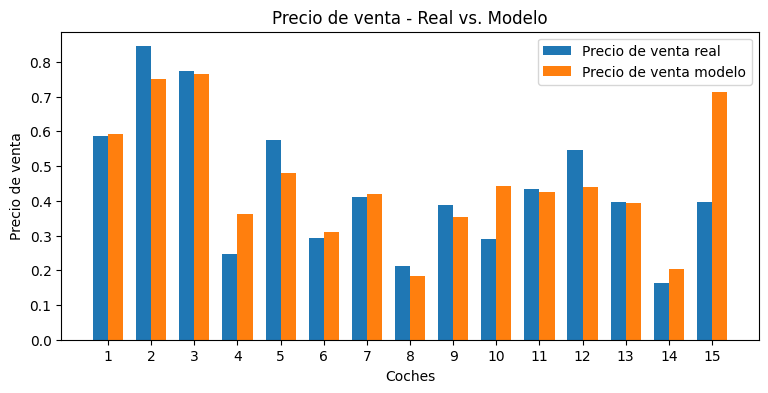

In [ ]:
from sklearn.linear_model import ARDRegression

ard_model = ARDRegression(compute_score=True)
ard_model.fit(X_train , y_train)
y_pred = ard_model.predict(X_test)

print(ard_model.score(X_train, y_train))
print(ard_model.score(X_val, y_val))
print(ard_model.score(X_test, y_test))

print ("MSE:", metrics.mean_squared_error(y_pred , y_test))
print ("R^2:", metrics.r2_score(y_pred , y_test))
print ("var:", y_pred.var(), y_test.var())

ind = np.arange(15)
width = 0.35

plt.figure(figsize=(9,4))
plt.bar(ind, y_test[:15], width, label='Precio de venta real')
plt.bar(ind+width, y_pred[:15], width, label='Precio de venta modelo')

plt.xticks(ind+width/2, np.arange(1, 16))
plt.legend(loc='best')

plt.xlabel('Coches')
plt.ylabel('Precio de venta')
plt.title('Precio de venta - Real vs. Modelo')

plt.show()

0.2607951241033204
0.256469369769299
0.259501158283173
MSE: 0.02638994515715795
R^2: -15.09289618519405
var: 0.0016398505808691846 0.03552480180852423


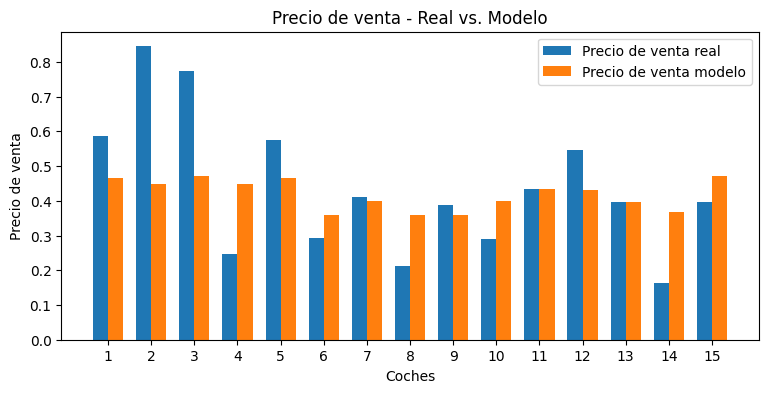

In [ ]:
from sklearn.linear_model import TweedieRegressor
tweed_model = TweedieRegressor(power=1, alpha=0.5, link='log')
tweed_model.fit(X_train , y_train)
y_pred = tweed_model.predict(X_test)

print(tweed_model.score(X_train, y_train))
print(tweed_model.score(X_val, y_val))
print(tweed_model.score(X_test, y_test))

print ("MSE:", metrics.mean_squared_error(y_pred , y_test))
print ("R^2:", metrics.r2_score(y_pred , y_test))
print ("var:", y_pred.var(), y_test.var())

ind = np.arange(15)
width = 0.35

plt.figure(figsize=(9,4))
plt.bar(ind, y_test[:15], width, label='Precio de venta real')
plt.bar(ind+width, y_pred[:15], width, label='Precio de venta modelo')

plt.xticks(ind+width/2, np.arange(1, 16))
plt.legend(loc='best')

plt.xlabel('Coches')
plt.ylabel('Precio de venta')
plt.title('Precio de venta - Real vs. Modelo')

plt.show()

## 6.2 Red neuronal